# Processing 16s rRNA sequences
Running locally on Mac or Linux system.

Testing on run of multiple samples so that I can try some of the visuals

### If you are running in Terminal (on Mac or on Linux Machine). 
Skip next step if using Virtual Boz

In [1]:
source activate qiime2-2019.7

### cd into folder with your sequences
Also need manifest file and metadata file.
See examples.

In [2]:
cd ~/Desktop/example_microbes     # For example
ls

FH1_manifest.csv		HB02-CM01_R1_001.fastq.gz
FH1_sample_metadata.tsv		HB02-CM01_R2_001.fastq.gz
HB01-FM01_R1_001.fastq.gz	HB03-EM01_R1_001.fastq.gz
HB01-FM01_R2_001.fastq.gz	HB03-EM01_R2_001.fastq.gz


#### Look at the manifest and metadata files

In [3]:
cat FH1_manifest.csv

sample-id,absolute-filepath,direction
FM01,$PWD/HB01-FM01_R1_001.fastq.gz,forward
FM01,$PWD/HB01-FM01_R2_001.fastq.gz,reverse
CM01,$PWD/HB02-CM01_R1_001.fastq.gz,forward
CM01,$PWD/HB02-CM01_R2_001.fastq.gz,reverse
EM01,$PWD/HB03-EM01_R1_001.fastq.gz,forward
EM01,$PWD/HB03-EM01_R2_001.fastq.gz,reverse


In [4]:
cat FH1_sample_metadata.tsv

#SampleID	BarcodeSequence	Type	Replicate
#q2:types	categorical	categorical	categorical
FM01	CCTACGGG	FM	first
CM01	CCTACGGG	CM	first
EM01	CCTACGGG	EM	first

## Import data into QIIME2
In this example, these are paired end 250 bp sequences from Illumina MiSeq.
For each of these commands you can type all on one line. Omit the "\" at the end of each line if you do that.

In [5]:
qiime tools import --type 'SampleData[PairedEndSequencesWithQuality]' \
    --input-path FH1_manifest.csv \
    --output-path FH1_demux.qza \
    --input-format 'PairedEndFastqManifestPhred33'

Imported FH1_manifest.csv as PairedEndFastqManifestPhred33 to FH1_demux.qza


Save as a visualization artifact using `demux summarize`

In [6]:
qiime demux summarize --i-data FH1_demux.qza --o-visualization FH1_demux.qzv

Saved Visualization to: FH1_demux.qzv


View the resulting qzv file on view.qiime2.org and determine where to trim primers and truncate sequences.
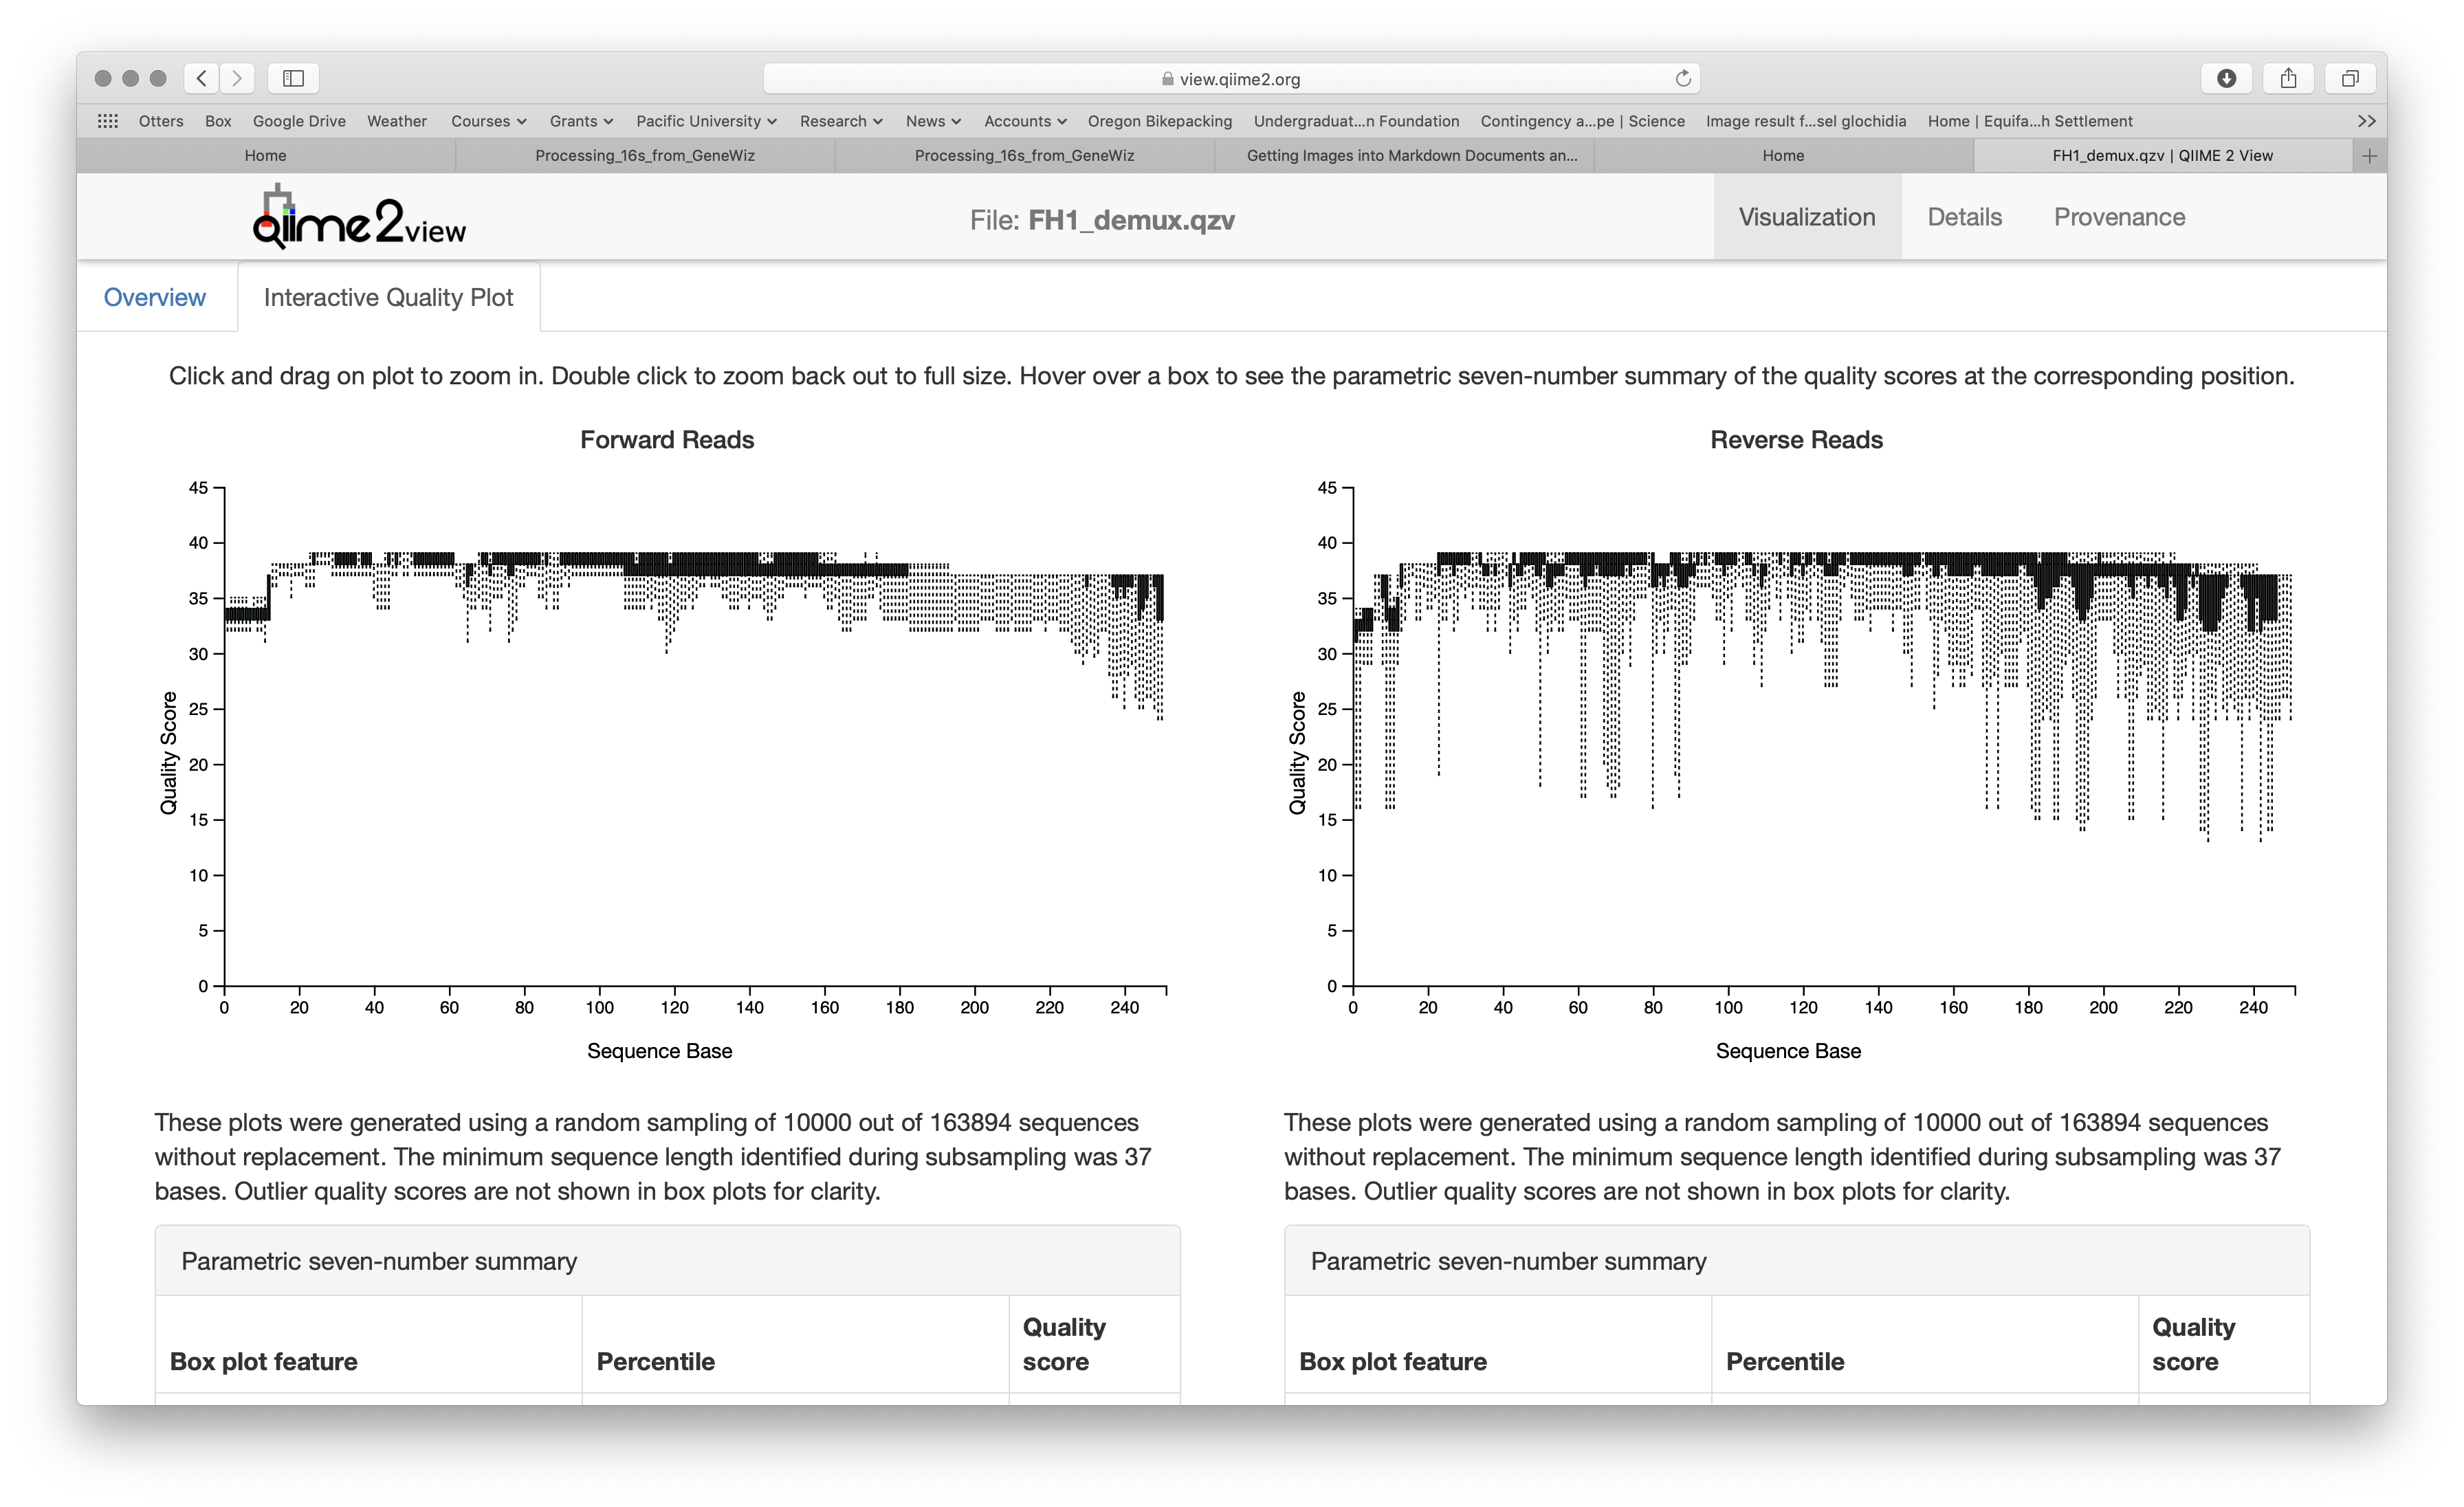

## Denoise Data
This step can take a long time. Run on Linux or on iMac in lab.

In [7]:
qiime dada2 denoise-paired \
    --i-demultiplexed-seqs FH1_demux.qza \
    --p-trim-left-f 12 \
    --p-trim-left-r 13 \
    --p-trunc-len-f 237 \
    --p-trunc-len-r 229 \
    --o-table FH1_table.qza \
    --o-representative-sequences FH1_rep-seqs.qza \
    --o-denoising-stats FH1_denoising-stats.qza

Saved FeatureTable[Frequency] to: FH1_table.qza
Saved FeatureData[Sequence] to: FH1_rep-seqs.qza
Saved SampleData[DADA2Stats] to: FH1_denoising-stats.qza


## Classify sequences
You will need a classifier to classify your sequences. There are two that I can give you... One is based on GreenGenes Database. The other is the SILVA database. Below are two different options with full paths to the classifiers. These are big files and I don't want to copy into every analysis folder.

### Using SILVA

In [8]:
# Using SILVA
qiime feature-classifier classify-sklearn \
  --i-classifier ~/Documents/QIIME2_Resources/silva99_16s_classifier.qza \
  --i-reads FH1_rep-seqs.qza \
  --o-classification FH1_SILVAtaxonomy.qza

Saved FeatureData[Taxonomy] to: FH1_SILVAtaxonomy.qza


In [9]:
qiime metadata tabulate \
  --m-input-file FH1_SILVAtaxonomy.qza \
  --o-visualization FH1_SILVAtaxonomy.qzv

Saved Visualization to: FH1_SILVAtaxonomy.qzv


### Using GreenGenes

In [11]:
qiime feature-classifier classify-sklearn \
  --i-classifier ~/Documents/QIIME2_Resources/gg-13-8-99-nb-classifier.qza \
  --i-reads FH1_rep-seqs.qza \
  --o-classification FH1_GGtaxonomy.qza

Saved FeatureData[Taxonomy] to: FH1_GGtaxonomy.qza


In [12]:
qiime metadata tabulate \
  --m-input-file FH1_GGtaxonomy.qza \
  --o-visualization FH1_GGtaxonomy.qzv

Saved Visualization to: FH1_GGtaxonomy.qzv


## Visualizations
Use the taxonomy files that you generated above. You'll need to change the input filenames accordingly. Also change the output filenames in such a way so that you can keep track of the results.

#### Make barplots based on taxonomy.
These show the proportion of reads for each taxa within a sample.

In [10]:
qiime taxa barplot \
    --i-table FH1_table.qza \
    --i-taxonomy FH1_SILVAtaxonomy.qza \
    --m-metadata-file FH1_sample_metadata.tsv \
    --o-visualization FH1_SILVAtaxa-bar-plots.qzv

Saved Visualization to: FH1_SILVAtaxa-bar-plots.qzv


In [13]:
qiime taxa barplot \
    --i-table FH1_table.qza \
    --i-taxonomy FH1_GGtaxonomy.qza \
    --m-metadata-file FH1_sample_metadata.tsv \
    --o-visualization FH1_GGtaxa-bar-plots.qzv

Saved Visualization to: FH1_GGtaxa-bar-plots.qzv


#### Make a phylogeny and use that to determine rarefactiion curve
Rarefaction curve is a taxon accumulation curve... it tells you if adding more sequences increases the richness/diversity or not. If your curve levels out, then you've sampled all that is there to be sampled (generally speaking).

In [14]:
qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences FH1_rep-seqs.qza \
  --o-alignment FH1_aligned-rep-seqs.qza \
  --o-masked-alignment FH1_masked-aligned-rep-seqs.qza \
  --o-tree FH1_unrooted-tree.qza \
  --o-rooted-tree FH1_rooted-tree.qza

Saved FeatureData[AlignedSequence] to: FH1_aligned-rep-seqs.qza
Saved FeatureData[AlignedSequence] to: FH1_masked-aligned-rep-seqs.qza
Saved Phylogeny[Unrooted] to: FH1_unrooted-tree.qza
Saved Phylogeny[Rooted] to: FH1_rooted-tree.qza


In [15]:
qiime diversity alpha-rarefaction \
  --i-table FH1_table.qza \
  --i-phylogeny FH1_rooted-tree.qza \
  --p-max-depth 4000 \
  --m-metadata-file FH1_sample_metadata.tsv  \
  --o-visualization FH1_alpha-rarefaction.qzv
  

Saved Visualization to: FH1_alpha-rarefaction.qzv


In [16]:
qiime diversity core-metrics-phylogenetic \
  --i-phylogeny FH1_rooted-tree.qza \
  --i-table FH1_table.qza \
  --p-sampling-depth 1103 \
  --m-metadata-file FH1_sample_metadata.tsv \
  --output-dir FH1_core-metrics-results

Saved FeatureTable[Frequency] to: FH1_core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: FH1_core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: FH1_core-metrics-results/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: FH1_core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: FH1_core-metrics-results/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: FH1_core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: FH1_core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: FH1_core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: FH1_core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: FH1_core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: FH1_core-metrics-results/weighted_unifrac_pcoa_results.qza
Sav

## To end your QIIME session type

In [17]:
conda deactivate
exit

exit
Saving session...
...saving history...truncating history files...
...completed.
Restarting Bash

# Note added Nov 11
To export as fasta... makes folder with one fasta file in it.
`qiime tools export --input-path FH1_rep-seqs.qza --output-path FH1_rep-seqs`

To export feature-table as BIOM output
`qiime tools export --input-path FH1_table.qza --output-path test`

`biom convert -i feature-table.biom -o otu_table.classic.txt --to-tsv --table-type 'OTU table' --header-key taxonomy`